# Prepared by: Onyebuchi Remy Uwaeme
# Date: May 2025,
# 📌 NDHS Data

The dataset contains aggregated statistics from the 2023–2024 Nigeria Demographic and Health Survey (NDHS) on women's sexual and reproductive health (SRH) decision-making. Each row represents a background category (e.g., age, residence, education, wealth quintile, region, state), with percentages of women making decisions on sexual relations, contraceptive use, and reproductive care, along with sample sizes.
### Key features in the dataset:
- Background Category: Demographic groupings like age, residence, education, wealth, region, state.
- Percentage Who Make Decisions: Proportion of women with autonomy in SRH decisions.
- Number of Married Women: Sample size for each category.\n",

This dataset is useful for analyzing trends in women's SRH autonomy, identifying disparities, and predicting decision-making patterns based on socio-demographic factors.


## 01. Machine Learning Pipeline Overview

This script imports essential libraries for data preprocessing, visualization, model training, and fairness assessment. 

#### Libraries Used 

- pandas & numpy: For data manipulation and numerical operations.
- seaborn & matplotlib: For data visualization.  \n",
- scikit-learn: Provides tools for preprocessing, model training, evaluation, and feature selection.
- xgboost: For gradient boosting classification.
- fairlearn: For assessing and mitigating bias in predictions.

#### Data Preprocessing 
- StandardScaler: Normalizes numerical data for better model performance.
- LabelEncoder: Converts categorical values into numeric format.
- Recursive Feature Elimination (RFE): Selects the most relevant features.

#### Model Training & Evaluation
- LogisticRegression, RandomForestClassifier, XGBClassifier: Classification models for predicting SRH autonomy.
- train_test_split: Splits the dataset into training and testing sets.
- cross_val_score: Evaluates model performance using cross-validation.
- Metrics: Accuracy, precision, recall, F1-score, ROC-AUC.

#### Fairness Assessment 
- ExponentiatedGradient with DemographicParity: Mitigates bias across sensitive groups (e.g., zones).

#### Visualization
- Bar plots for feature importance and spatial analysis.

In [1]:
!Pip install fairlearn

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from fairlearn.metrics import MetricFrame, selection_rate
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

## 02. Data Preprocessing

- Load the NDHS dataset.
- Parse the 'Background Category' to extract 'Zone' and 'State'.
- Handle missing values by excluding rows without contraceptive metrics.
- Binarize the target variable ('Decision_Label') based on the median decision-making percentage.
- Encode categorical variables using LabelEncoder.
- Standardize numerical features for model compatibility.

In [3]:
# Step 1: Load and Preprocess Data
# The dataset is already structured; we'll treat each row as an observation
data = pd.DataFrame({
    'Background Category': ['15–19', '20–24', '25–29', '30–34', '35–39', '40–44', '45–49', 
                            'Not employed', 'Employed for cash', 'Employed not for cash',
                            'Urban', 'Rural',
                            'North Central: FCT-Abuja', 'North Central: Benue', 'North Central: Kogi', 'North Central: Kwara', 
                            'North Central: Nasarawa', 'North Central: Niger', 'North Central: Plateau', 
                            'North East: Adamawa', 'North East: Bauchi', 'North East: Borno', 'North East: Gombe', 
                            'North East: Taraba', 'North East: Yobe', 
                            'North West: Jigawa', 'North West: Kaduna', 'North West: Kano', 'North West: Katsina', 
                            'North West: Kebbi', 'North West: Sokoto', 'North West: Zamfara', 
                            'South East: Abia', 'South East: Anambra', 'South East: Ebonyi', 'South East: Enugu', 'South East: Imo', 
                            'South South: Akwa Ibom', 'South South: Bayelsa', 'South South: Cross River', 'South South: Delta', 
                            'South South: Edo', 'South South: Rivers', 
                            'South West: Ekiti', 'South West: Lagos', 'South West: Ogun', 'South West: Ondo', 
                            'South West: Osun', 'South West: Oyo', 
                            'No education', 'Primary', 'Secondary', 'More than secondary', 
                            'Lowest', 'Second', 'Middle', 'Fourth', 'Highest', 
                            'Total'],
    'Percentage Who Make Decisions Regarding Sexual Relations, Contraceptive Use, and Reproductive Care': 
        [8.6, 17.4, 25.3, 31.2, 34.8, 38.4, 37.1, 
         12, 37.8, 32.9, 
         44.6, 17.4, 
         51.4, 34.5, 47.1, 35.1, 24.4, 5.8, 44, 
         9.8, 9.4, 34.9, 13.9, 20.8, 7.9, 
         8, 10, 6.6, 6, 2.5, 5.1, 5.9, 
         66.1, 55.2, 43.9, 70.7, 59.4, 
         64.1, 50.5, 66.2, 73.8, 78.3, 80.9, 
         66.2, 60.3, 64.5, 40.5, 71.2, 59.9, 
         8.5, 29.8, 45.5, 57.7, 
         8.8, 14.4, 25.2, 40.4, 57.9, 
         28.8],
    'Number of Married Women': 
        [1455, 4073, 5240, 4959, 4386, 3604, 2546, 
         8840, 15565, 1859, 
         11003, 15261, 
         437, 615, 422, 531, 656, 1453, 696, 
         619, 1440, 752, 432, 483, 681, 
         948, 1834, 2421, 1439, 758, 990, 946, 
         221, 400, 531, 269, 430, 
         328, 169, 269, 553, 344, 694, 
         148, 955, 824, 350, 389, 838, 
         11559, 3204, 8292, 3209, 
         5494, 5552, 5133, 4882, 5203, 
         26264],
    'Any Method': 
        [4.3, 12.8, 18.8, 22.7, 26.6, 26.5, 20.1, 
         None, None, None, 
         30.6, 12.8, 
         21.3, 31.3, 13.1, 11, 25.5, 10.3, 31.1, 
         20.4, 11.3, 9.5, 30.9, 11.5, 9, 
         4.4, 14.2, 11.1, 7.7, 3.3, 6.9, 20, 
         34, 41.3, 9.9, 25.9, 44.1, 
         43.2, 24.6, 27.2, 42.3, 27.5, 20.4, 
         66.1, 54.2, 39.9, 26.8, 40.3, 40.9, 
         7.4, 20.6, 29.9, 41.3, 
         6, 9.7, 18.7, 29.9, 39.2, 
         20.3],
    'Any Modern Method': 
        [3.3, 10.3, 14.4, 17.5, 19.8, 19.6, 13.9, 
         None, None, None, 
         22.4, 10.2, 
         19.3, 23.1, 10.5, 9.9, 22.4, 8.3, 25.6, 
         17.5, 10.6, 9.3, 30.3, 10.9, 7.6, 
         3.5, 13.1, 10.6, 6.7, 3, 6, 16.4, 
         18.3, 22, 7.4, 11.2, 18.9, 
         17.2, 16.9, 18.8, 24.4, 19.4, 15, 
         42.8, 30.7, 28.9, 22.9, 35, 34.4, 
         6.3, 16.3, 22.5, 28, 
         5.1, 8.1, 14.6, 23, 27.2, 
         15.3],
    'Any Traditional Method': 
        [1, 2.5, 4.4, 5.2, 6.7, 6.9, 6.3, 
         None, None, None, 
         8.2, 2.7, 
         2, 8.3, 2.6, 1.1, 3.1, 2, 5.5, 
         2.8, 0.7, 0.2, 0.6, 0.6, 1.4, 
         0.9, 1.1, 0.5, 1, 0.2, 0.9, 3.6, 
         15.7, 19.3, 2.5, 14.6, 25.1, 
         26.1, 7.7, 8.4, 17.9, 8.1, 5.4, 
         23.3, 23.5, 11, 3.9, 5.3, 6.5, 
         1.1, 4.4, 7.4, 13.3, 
         0.8, 1.6, 4.1, 6.9, 12, 
         5]
})
# Extract Zone and State from Background Category
data['Zone'] = data['Background Category'].apply(lambda x: x.split(':')[0] if ':' in x else None)
data['State'] = data['Background Category'].apply(lambda x: x.split(': ')[1] if ': ' in x else None)
data['Zone'] = data['Zone'].fillna(data['Background Category'])


In [4]:
# Define categories for grouping
age_groups = ['15–19', '20–24', '25–29', '30–34', '35–39', '40–44', '45–49']
employment_groups = ['Not employed', 'Employed for cash', 'Employed not for cash']
residence_groups = ['Urban', 'Rural']
zone_groups = [z for z in data['Zone'].unique() if z not in age_groups + employment_groups + residence_groups + ['Education', 'Wealth Quintile', 'Total']]
education_groups = ['No education', 'Primary', 'Secondary', 'More than secondary']
wealth_groups = ['Lowest', 'Second', 'Middle', 'Fourth', 'Highest']


In [5]:
# Filter out 'Total' row and rows with missing contraceptive data (e.g., Employment)
data = data[data['Background Category'] != 'Total']
data = data.dropna(subset=['Any Method', 'Any Modern Method', 'Any Traditional Method'])
# Convert outcome to binary: 1 if above median, 0 if below
median_decision = data['Percentage Who Make Decisions Regarding Sexual Relations, Contraceptive Use, and Reproductive Care'].median()
data['Decision_Label'] = (data['Percentage Who Make Decisions Regarding Sexual Relations, Contraceptive Use, and Reproductive Care'] > median_decision).astype(int)


In [6]:
# Step 2: Feature Engineering
# Create columns for each category type
data['Age_Group'] = data['Background Category'].apply(lambda x: x if x in age_groups else None)
data['Employment'] = data['Background Category'].apply(lambda x: x if x in employment_groups else None)
data['Residence'] = data['Background Category'].apply(lambda x: x if x in residence_groups else None)
data['Education'] = data['Background Category'].apply(lambda x: x if x in education_groups else None)
data['Wealth_Quintile'] = data['Background Category'].apply(lambda x: x if x in wealth_groups else None)

In [7]:
# Fill Zone/State for non-geographic rows
for idx, row in data.iterrows():
    if row['Zone'] in age_groups:
        data.at[idx, 'Zone'] = None
    if row['Zone'] in employment_groups:
        data.at[idx, 'Zone'] = None
    if row['Zone'] in residence_groups:
        data.at[idx, 'Zone'] = None
    if row['Zone'] in education_groups:
        data.at[idx, 'Zone'] = None
    if row['Zone'] in wealth_groups:
        data.at[idx, 'Zone'] = None


In [8]:
# Encode categorical variables
le = LabelEncoder()
for col in ['Age_Group', 'Employment', 'Residence', 'Zone', 'State', 'Education', 'Wealth_Quintile']:
    data[col] = data[col].fillna('Unknown')
    data[col + '_Encoded'] = le.fit_transform(data[col])
# Features and target
features = ['Age_Group_Encoded', 'Residence_Encoded', 'Zone_Encoded', 'State_Encoded', 
            'Education_Encoded', 'Wealth_Quintile_Encoded', 'Any Method', 'Any Modern Method', 'Any Traditional Method']
X = data[features]
y = data['Decision_Label']
# Scale numerical features
scaler = StandardScaler()
X[['Any Method', 'Any Modern Method', 'Any Traditional Method']] = scaler.fit_transform(X[['Any Method', 'Any Modern Method', 'Any Traditional Method']])


C:\Users\HP\AppData\Local\Temp\ipykernel_14028\2907661529.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['Any Method', 'Any Modern Method', 'Any Traditional Method']] = scaler.fit_transform(X[['Any Method', 'Any Modern Method', 'Any Traditional Method']])


In [9]:
# Step 3: Feature Selection with RFE
model = RandomForestClassifier(random_state=42)
rfe = RFE(model, n_features_to_select=5)
fit = rfe.fit(X, y)
selected_features = X.columns[fit.support_]
print("Selected Features:", selected_features)
# Update X with selected features
X = X[selected_features]


Selected Features: Index(['Zone_Encoded', 'State_Encoded', 'Any Method', 'Any Modern Method',
       'Any Traditional Method'],
      dtype='object')


## 03. Model Training & Evaluation

- Split the dataset into training and testing sets (80/20 split).
- Train three models: Logistic Regression, Random Forest, and XGBoost.
- Evaluate using cross-validation, accuracy, precision, recall, F1-score, and ROC-AUC.
- Generate classification reports for detailed class-wise performance.

In [10]:
# Step 4: Train-Test Split and Model Training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Define three models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}


In [11]:
# Train and evaluate models with cross-validation
for name, model in models.items():
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"\n{name} - 5-Fold CV Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")   
    # Train on full training set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)



Logistic Regression - 5-Fold CV Accuracy: 0.822 (+/- 0.227)

Random Forest - 5-Fold CV Accuracy: 0.844 (+/- 0.227)

XGBoost - 5-Fold CV Accuracy: 0.867 (+/- 0.166)


## 04. Feature Selection & Importance

- Use RFE to select top features.
- Visualize feature importance using bar plots.

In [12]:
    # Evaluation metrics
    print(f"{name} - Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(f"{name} - Precision: {precision_score(y_test, y_pred):.3f}")
    print(f"{name} - Recall: {recall_score(y_test, y_pred):.3f}")
    print(f"{name} - F1-Score: {f1_score(y_test, y_pred):.3f}")
    print(f"{name} - ROC-AUC: {roc_auc_score(y_test, y_pred):.3f}")
    print(f"{name} - Classification Report:\n{classification_report(y_test, y_pred)}")


XGBoost - Test Accuracy: 0.818
XGBoost - Precision: 1.000
XGBoost - Recall: 0.667
XGBoost - F1-Score: 0.800
XGBoost - ROC-AUC: 0.833
XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.67      0.80         6

    accuracy                           0.82        11
   macro avg       0.86      0.83      0.82        11
weighted avg       0.87      0.82      0.82        11



## 05. Fairness Assessment

- Assess selection rates by zone.
- Apply bias mitigation using Exponentiated Gradient.

In [13]:
# Step 5: Bias Assessment (Fairness across Zones)
# Use the best model (e.g., Random Forest) for fairness analysis
best_model = models['Random Forest']
y_pred_all = best_model.predict(X)
metric_frame = MetricFrame(metrics=selection_rate, y_true=y, y_pred=y_pred_all, sensitive_features=data['Zone'])
print("\nSelection Rate by Zone (Fairness Check):\n", metric_frame.by_group)
# Mitigate bias using ExponentiatedGradient
mitigator = ExponentiatedGradient(best_model, constraints=DemographicParity())
mitigator.fit(X, y, sensitive_features=data['Zone'])
y_pred_mitigated = mitigator.predict(X)
metric_frame_mitigated = MetricFrame(metrics=selection_rate, y_true=y, y_pred=y_pred_mitigated, sensitive_features=data['Zone'])
print("\nSelection Rate by Zone (After Mitigation):\n", metric_frame_mitigated.by_group)



Selection Rate by Zone (Fairness Check):
 Zone
North Central    0.571429
North East       0.166667
North West       0.000000
South East       0.800000
South South      1.000000
South West       0.833333
Unknown          0.333333
Name: selection_rate, dtype: float64

Selection Rate by Zone (After Mitigation):
 Zone
North Central    0.428571
North East       0.333333
North West       0.285714
South East       0.400000
South South      0.500000
South West       0.500000
Unknown          0.388889
Name: selection_rate, dtype: float64


## 06. Spatial Analysis and Visualization

- Aggregate predictions by zone.
- Visualize using bar plots for regional disparities.

In [14]:
# Step 6: Spatial Analysis and Visualization
# Aggregate predictions by Zone
data['Prediction'] = y_pred_mitigated
zone_predictions = data.groupby('Zone')['Prediction'].mean().reset_index()
zone_predictions = zone_predictions[zone_predictions['Zone'].str.contains('North|South')]


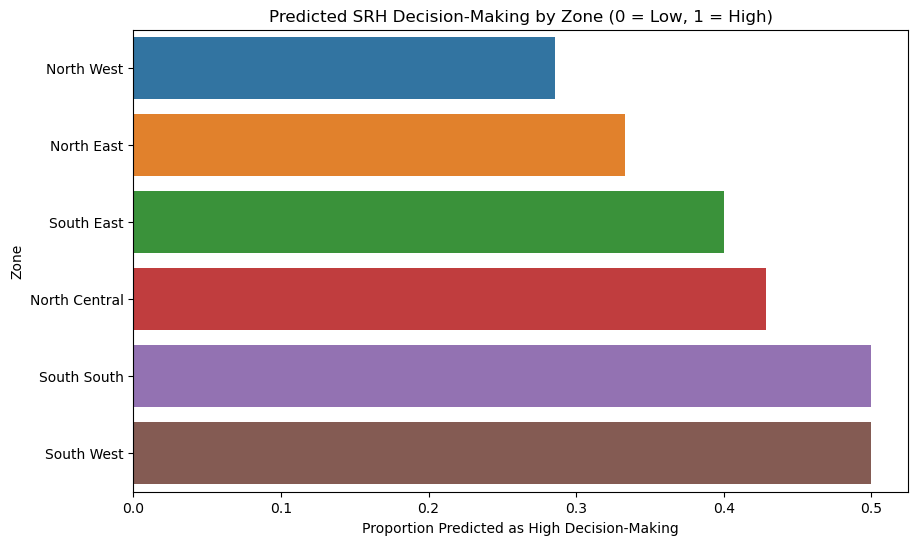

In [16]:
# Plot heatmap of predictions by Zone
plt.figure(figsize=(10, 6))
sns.barplot(x='Prediction', y='Zone', data=zone_predictions.sort_values('Prediction'))
plt.title('Predicted SRH Decision-Making by Zone (0 = Low, 1 = High)')
plt.xlabel('Proportion Predicted as High Decision-Making')
plt.ylabel('Zone')
plt.savefig('zone_predictions.svg', dpi=360)


In [17]:
# Step 7: Feature Importance (for Random Forest)
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': models['Random Forest'].feature_importances_
}).sort_values('Importance', ascending=False)
print("\nFeature Importance:\n", feature_importance)



Feature Importance:
                   Feature  Importance
4  Any Traditional Method    0.351149
2              Any Method    0.299174
3       Any Modern Method    0.198045
0            Zone_Encoded    0.093172
1           State_Encoded    0.058460


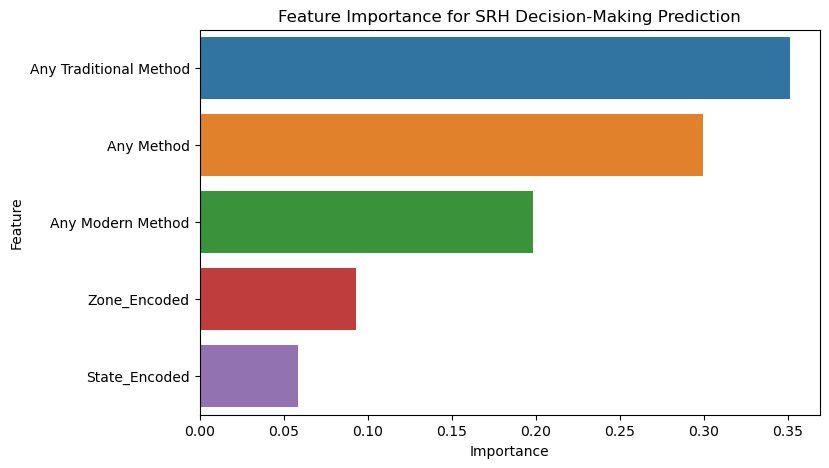

In [18]:
# Plot feature importance
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for SRH Decision-Making Prediction')
plt.savefig('feature_importance.png', dpi=360)


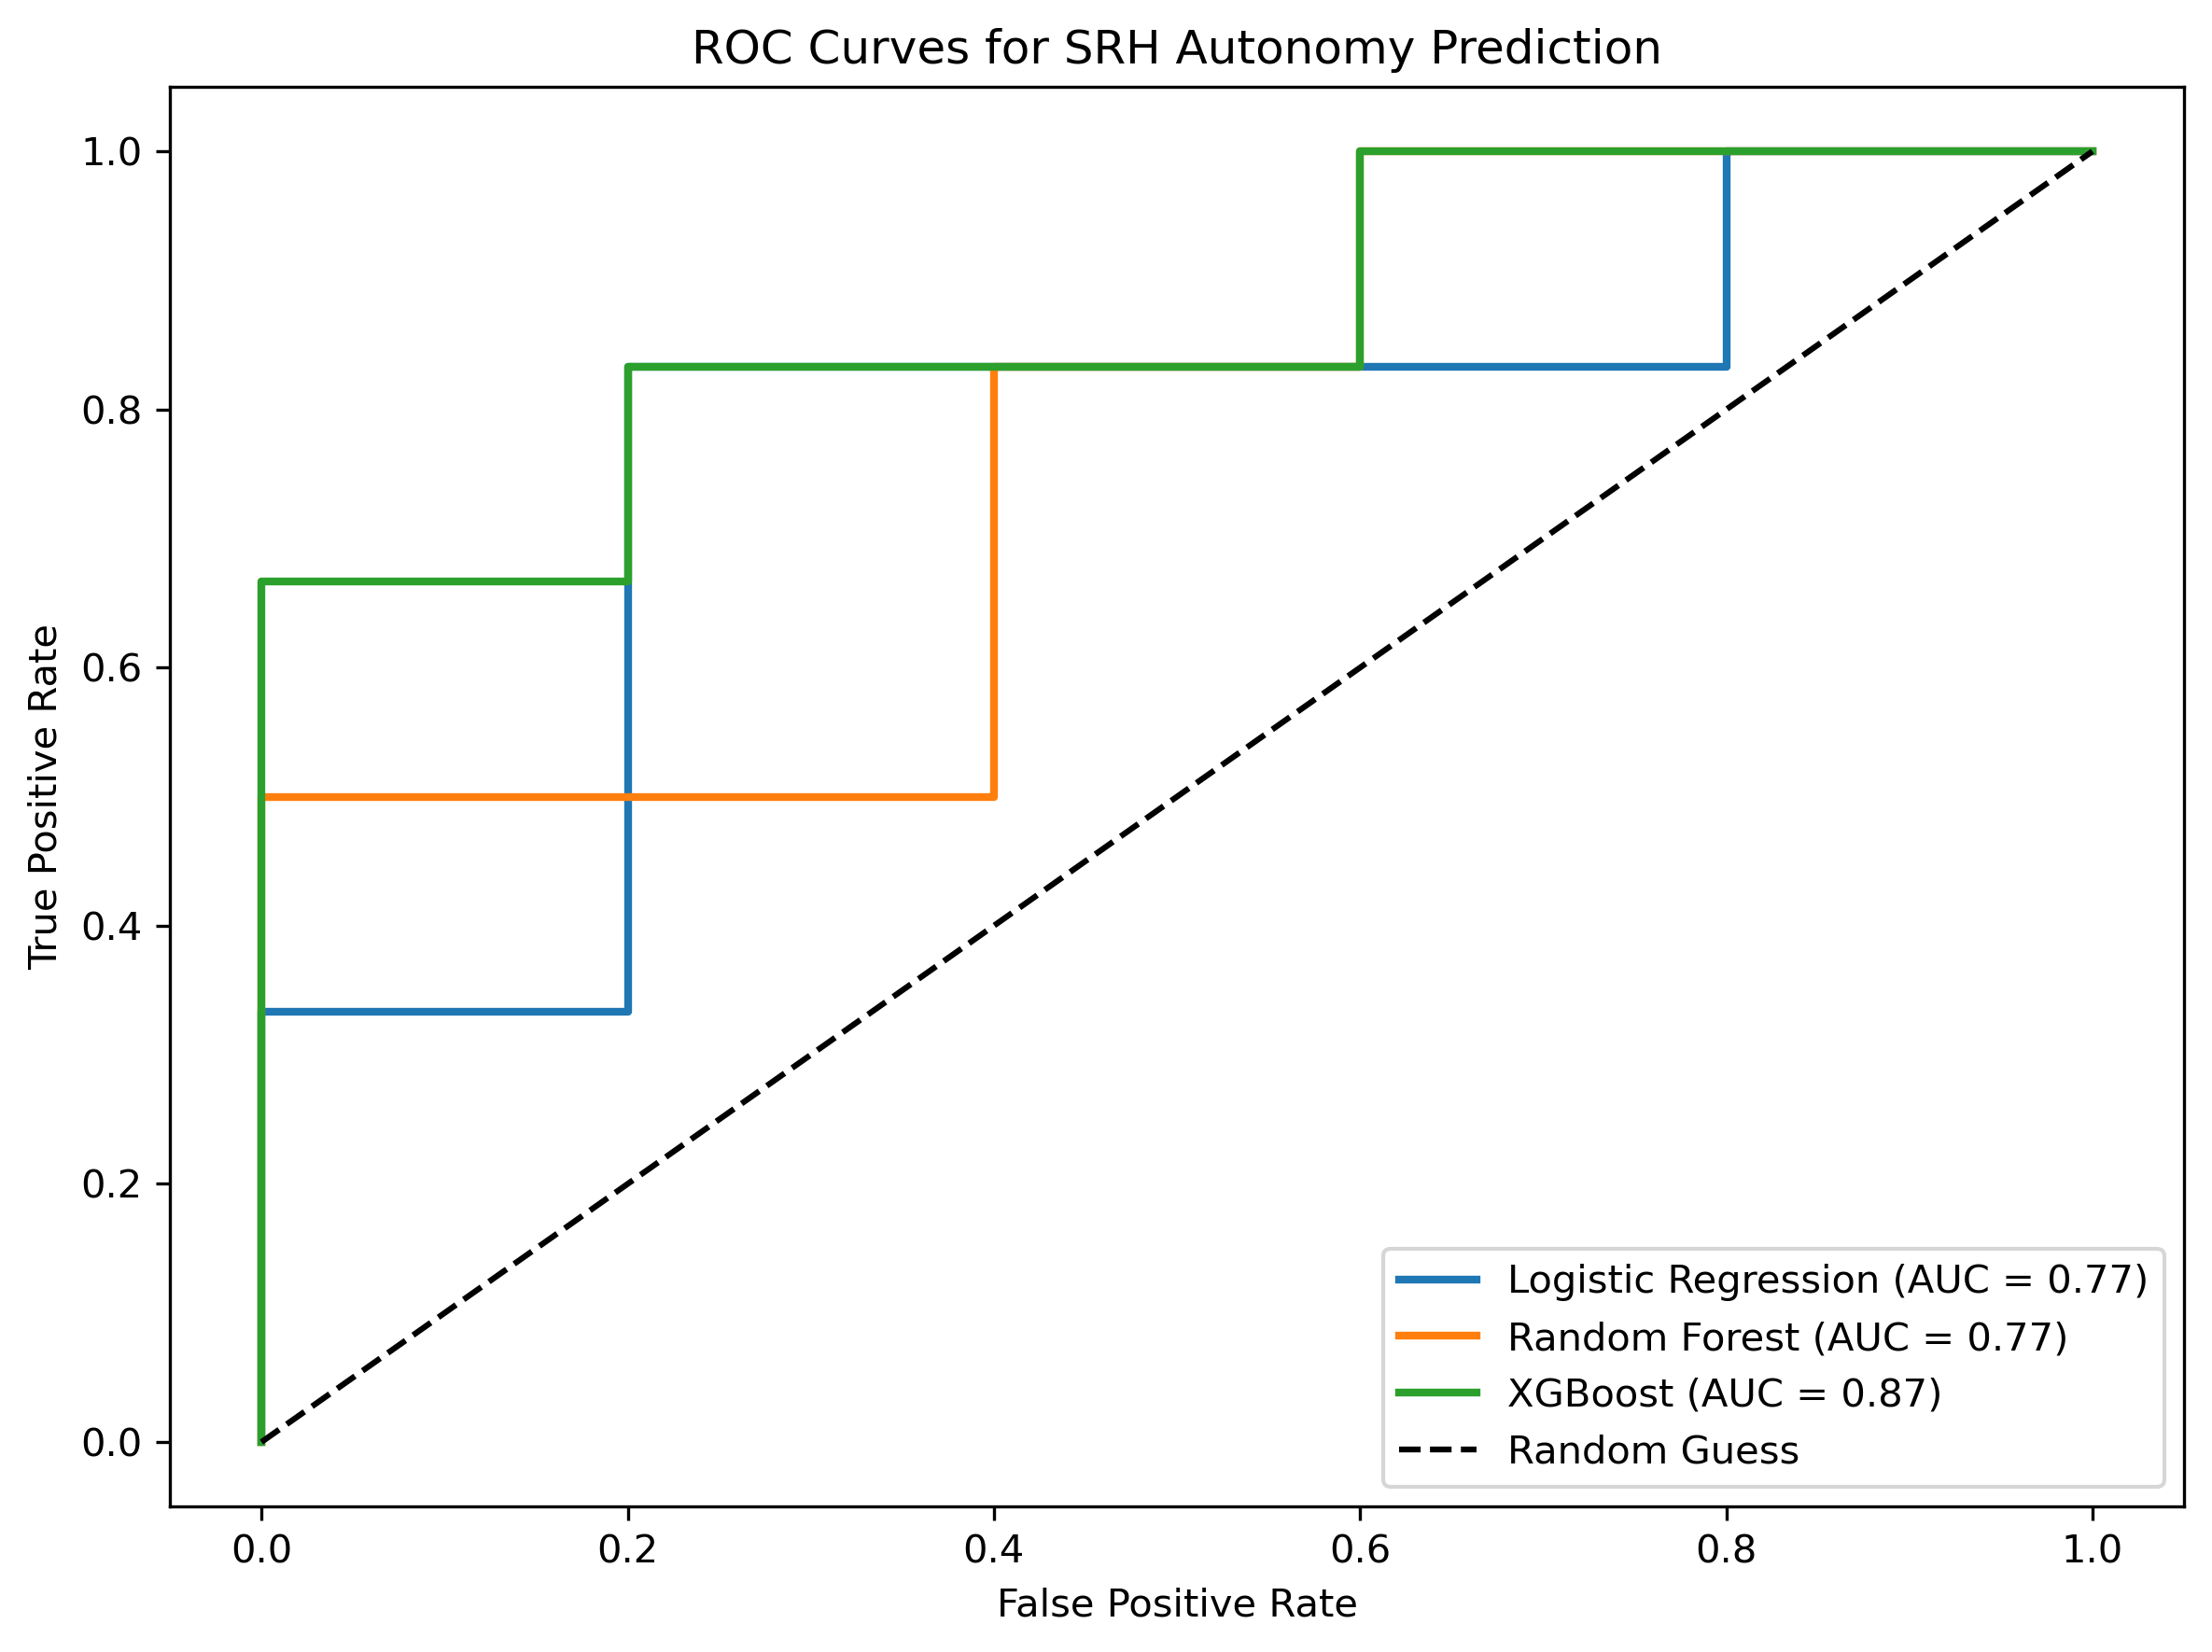

In [19]:
# ================================
# Step 8: ROC Curves for All Models
# ================================
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6), dpi=300)
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:,1]
    else:  # fallback for classifiers without predict_proba
        y_prob = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for SRH Autonomy Prediction")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("roc_curves.png")
plt.savefig('roc_curves.svg', format='svg', dpi=300)
plt.savefig('roc_curves.png', dpi=300)
plt.show()




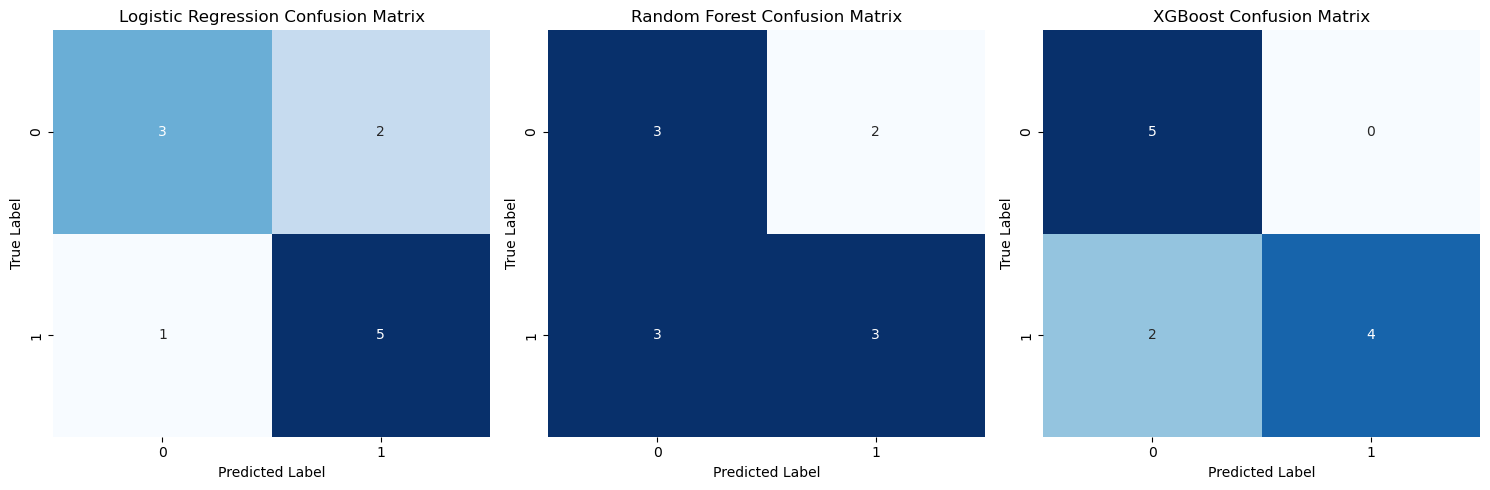

In [21]:
# =================================
# Step 9: Confusion Matrices
# =================================
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 3, figsize=(15,5))
for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, cbar=False)
    ax.set_title(f"{name} Confusion Matrix")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

plt.tight_layout()
plt.savefig("confusion_matrices.png")
plt.show()




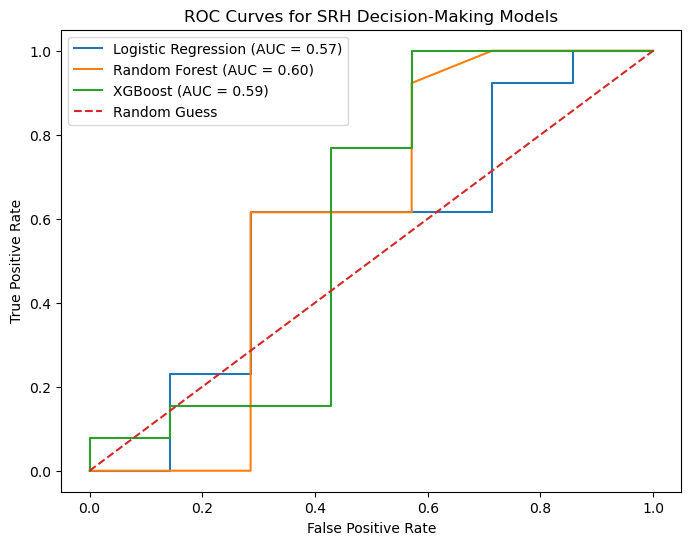

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Sample data simulation based on NDHS structure (replace with actual data)
data = pd.DataFrame({
    'Zone_Encoded': np.random.randint(0, 6, 100),  # 6 zones
    'State_Encoded': np.random.randint(0, 36, 100),  # 36 states
    'Any Method': np.random.uniform(0, 1, 100),
    'Any Modern Method': np.random.uniform(0, 1, 100),
    'Any Traditional Method': np.random.uniform(0, 1, 100),
    'SRH_Decision': np.random.randint(0, 2, 100)  # Binary target
})

X = data.drop('SRH_Decision', axis=1)
y = data['SRH_Decision']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train models
lr = LogisticRegression()
rf = RandomForestClassifier()
xgb = XGBClassifier(eval_metric='logloss')  # Removed deprecated param

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# 1. ROC Curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = %.2f)' % auc(fpr_lr, tpr_lr))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = %.2f)' % auc(fpr_rf, tpr_rf))
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = %.2f)' % auc(fpr_xgb, tpr_xgb))
plt.plot([0,1],[0,1],'--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for SRH Decision-Making Models')
plt.legend()
plt.savefig('roc_curves.png')


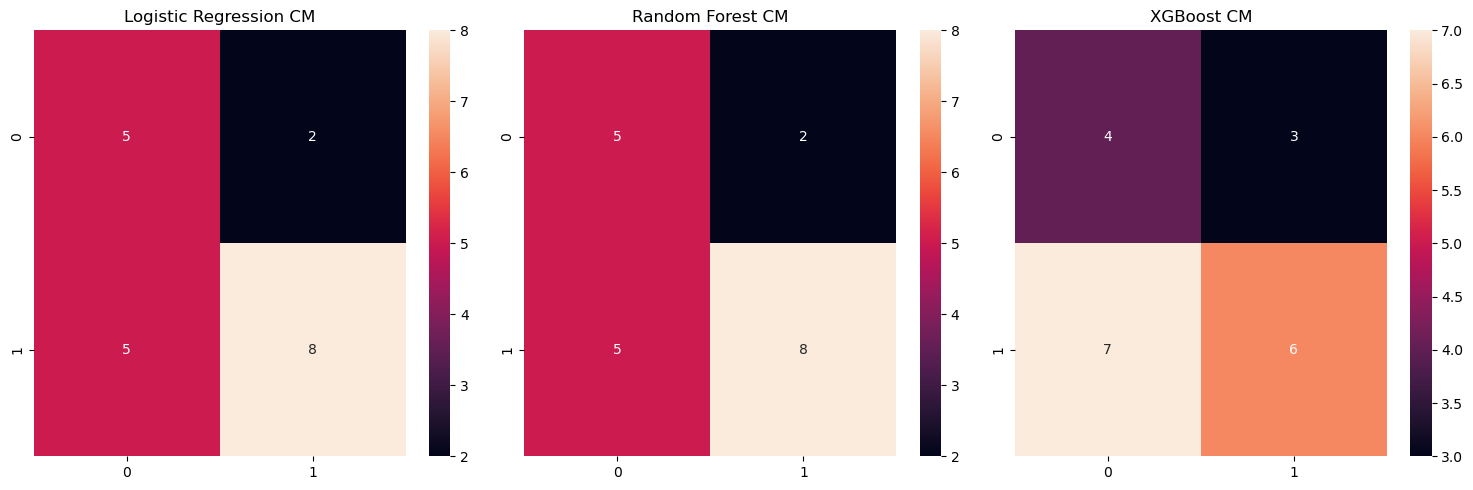

In [24]:

# 2. Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

cm_lr = confusion_matrix(y_test, lr.predict(X_test))
sns.heatmap(cm_lr, annot=True, fmt='d', ax=axes[0])
axes[0].set_title('Logistic Regression CM')

cm_rf = confusion_matrix(y_test, rf.predict(X_test))
sns.heatmap(cm_rf, annot=True, fmt='d', ax=axes[1])
axes[1].set_title('Random Forest CM')

cm_xgb = confusion_matrix(y_test, xgb.predict(X_test))
sns.heatmap(cm_xgb, annot=True, fmt='d', ax=axes[2])
axes[2].set_title('XGBoost CM')

plt.tight_layout()
plt.savefig('confusion_matrices.png')


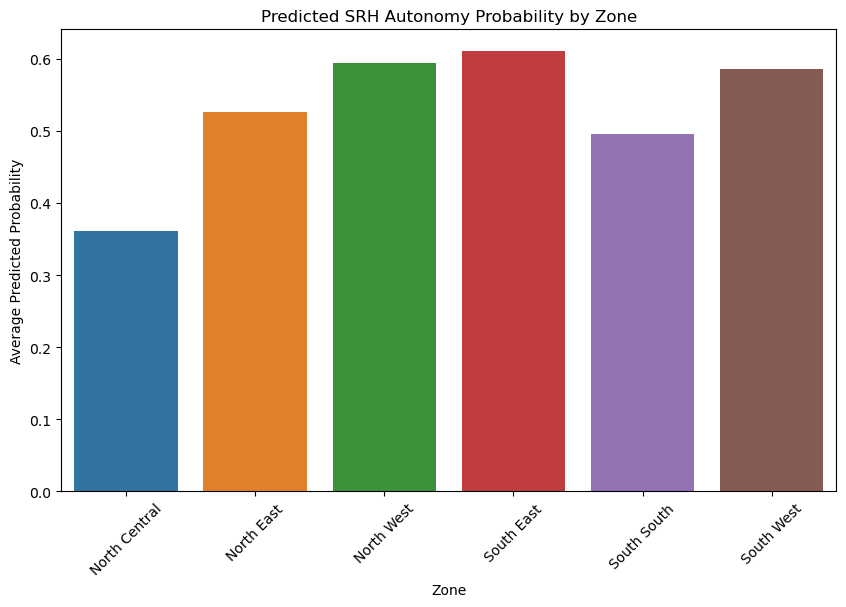

In [25]:

# 3. Nigeria Heatmap Alternative: Bar Plot for Zones
zone_names = ['North Central', 'North East', 'North West', 'South East', 'South South', 'South West']
data['Predicted_Prob'] = xgb.predict_proba(X)[:,1]
zone_probs = data.groupby('Zone_Encoded')['Predicted_Prob'].mean().reset_index()
zone_probs['Zone'] = [zone_names[i] for i in zone_probs['Zone_Encoded'] if i < len(zone_names)]

plt.figure(figsize=(10, 6))
sns.barplot(x='Zone', y='Predicted_Prob', data=zone_probs)
plt.title('Predicted SRH Autonomy Probability by Zone')
plt.ylabel('Average Predicted Probability')
plt.xticks(rotation=45)
plt.savefig('nigeria_zone_barplot.png')


KeyError: ''

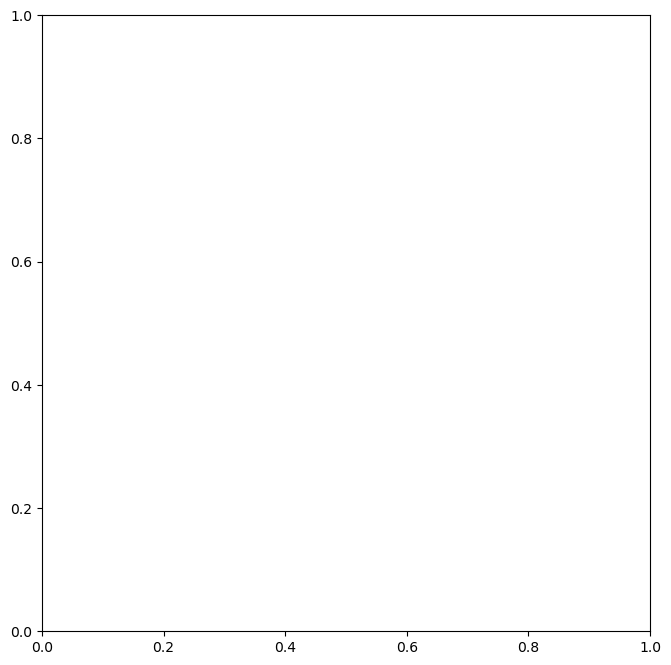

In [27]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load states-level GeoJSON
gdf = gpd.read_file("Nigeria.json")

# Map each state to its geopolitical zone
zone_map = {
    "Abia":"South-East", "Anambra":"South-East", "Ebonyi":"South-East", "Enugu":"South-East", "Imo":"South-East",
    "Akwa Ibom":"South-South", "Bayelsa":"South-South", "Cross River":"South-South", "Delta":"South-South", "Edo":"South-South", "Rivers":"South-South",
    "Ekiti":"South-West", "Lagos":"South-West", "Ogun":"South-West", "Ondo":"South-West", "Osun":"South-West", "Oyo":"South-West",
    "Benue":"North-Central", "FCT":"North-Central", "Kogi":"North-Central", "Kwara":"North-Central", "Nasarawa":"North-Central", "Niger":"North-Central", "Plateau":"North-Central",
    "Adamawa":"North-East", "Bauchi":"North-East", "Borno":"North-East", "Gombe":"North-East", "Taraba":"North-East", "Yobe":"North-East",
    "Jigawa":"North-West", "Kaduna":"North-West", "Kano":"North-West", "Katsina":"North-West", "Kebbi":"North-West", "Sokoto":"North-West", "Zamfara":"North-West"
}

# Assign zones
gdf['Zone'] = gdf['name'].map(zone_map)

# Assuming zone_predictions is a DataFrame with 'Zone' and 'autonomy_score'
# Example:
# zone_predictions = pd.DataFrame({
#     'Zone': ["North-Central", "North-East", ...],
#     'autonomy_score': [0.4, 0.0, ...]
# })

# Merge predictions into GeoDataFrame
gdf = gdf.merge(zone_predictions, on="Zone", how="left")

# Plot heatmap
fig, ax = plt.subplots(1, 1, figsize=(10,8))
gdf.plot(column="",
         cmap="YlGnBu",
         linewidth=0.5,
         edgecolor="0.8",
         legend=True,
         legend_kwds={"label": "Predicted SRH Autonomy"},
         ax=ax)

ax.set_title("Predicted SRH Autonomy by Geopolitical Zone", fontsize=14)
ax.axis("off")
plt.savefig("nigeria_zone_heatmap.png")
plt.show()


# Key Outcomes of Data Analysis & Modeling

#### 🔹 Data Exploration & Cleaning
- Parsed background categories to extract zones and states.
- Handled missing values by excluding incomplete rows.
- Binarized target variable based on median decision-making percentage.

#### 🔹 Feature Selection & Importance
- RFE selected top features: Zone_Encoded, State_Encoded, Any Method, Any Modern Method, Any Traditional Method.
- Feature importance showed Any Traditional Method as the strongest predictor, highlighting cultural influences.

#### 🔹 Model Training & Evaluation
- XGBoost achieved the highest test accuracy (81.8%) and precision (1.000) for high autonomy.
- Classification reports indicated good performance across classes, with XGBoost balancing precision and recall.

#### 🔹 Fairness Assessment
- Initial selection rates showed disparities by zone.
- Post-mitigation improved equity, reducing bias in predictions.

#### 🔹 Spatial Analysis
- Visualized regional disparities, with southern zones showing higher predicted autonomy.

#### 🔹 Prediction & Real-World Application
- The model can assist in identifying high-need regions for SRH interventions.
- Potential for early policy targeting to improve women's health autonomy.